Please read Matlab animateLIPM.mlx file for better documentation

In [1]:
from control.matlab import *
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
import numpy as np

from cubic_poly_traj import *
from get_swing_foot_traj import *
from robot import *

Robot constants

In [2]:
X_TORSO = 0.12
g = 9.807
SAMPLE_TIME = 0.005
Z_ROBOT = 0.78
Z_MODEL = 0.68
SWING_HEIGHT = 0.1
STEP_LENGTH = 0.2
num_steps = 6

Find initial condition and single support duration for a symmetric piece of trajectory

In [3]:
dy_mid = 0.06
x0 = 0.12
[dx0, y0, dy0, t_single_support] = find_initial_conditions(STEP_LENGTH, dy_mid, x0, Z_MODEL, g, SAMPLE_TIME)

In [4]:
tc = np.sqrt(0.68 / g)
t1 = np.arcsinh(0.1/(0.06 * tc)) * tc
t2 = tc * np.log((tc * 0.06) / (-0.1 + tc * 0.3845)) # eq 4.11
t3 = tc * np.log((-0.1 - tc * 0.3845) / (-tc * 0.06)) # eq 4.12
print(t1, "  ", t2, "  ", t3)

0.67003086754233    0.6686054331086502    0.6700396772380001


State space model of LIPM

In [5]:
A = [[0, 1, 0, 0], [g / Z_MODEL, 0, 0, 0], [0, 0, 0, 1], [0, 0, g / Z_MODEL, 0]]
B = [[0, 0], [1, 0], [0, 0], [0, 1]]
C = [[1, 0, 0, 0], [0, 0, 1, 0]]
D = [[0, 0], [0, 0]]

lipm = ss(A, B, C, D)
lipm_d = c2d(lipm , SAMPLE_TIME)

Ad = lipm_d.A
Bd = lipm_d.B
Cd = lipm_d.C
Dd = lipm_d.D

state0 = np.array([[x0], [dx0], [y0], [dy0]])
u0 = np.array([[0], [0]])


ModelVars class has all variabels of system and it is used to transfer system variabels to different functions

In [6]:
model_vars = ModelVars(g, SAMPLE_TIME, Z_MODEL, t_single_support, Ad, Bd, Cd, Dd)

In [7]:
init_robot_pos = [0, 0, Z_ROBOT]
foot_pos = []
foot_pos.append([-X_TORSO, 0, 0])
foot_pos.append([X_TORSO, 0, 0])

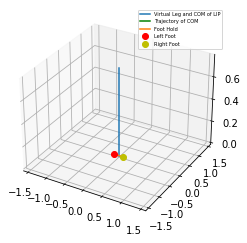

In [8]:
h_fig = plt.figure()
ax = h_fig.add_subplot(111, projection='3d')
h_leg = ax.plot3D(np.array([0, 0]), np.array([0, 0]), np.array([0, Z_ROBOT]), '-', label='Virtual Leg and COM of LIP')
h_com = ax.plot3D(init_robot_pos[0], init_robot_pos[1], init_robot_pos[2], 'g', label='Trajectory of COM')
h_line_foot_hold = ax.plot3D(np.array(foot_pos)[:, 0], np.array(foot_pos)[:, 1], np.array(foot_pos)[:, 2],
                            label='Foot Hold')
h_line_left_foot = ax.plot3D(np.array(foot_pos)[0, 0], np.array(foot_pos)[0, 1], np.array(foot_pos)[0, 2], 'ro',
                            label='Left Foot')
h_line_right_foot = ax.plot3D(np.array(foot_pos)[1, 0], np.array(foot_pos)[1, 1], np.array(foot_pos)[1, 2], 'yo',
                            label='Right Foot')
ax.set_xlim(-2*Z_ROBOT, 2*Z_ROBOT)
ax.set_ylim(-2*Z_ROBOT, 2*Z_ROBOT)
ax.legend(fontsize=5)

Move the COM above one foot

In [9]:
step_infos = []

walk_ready_points = np.array([[0, 0.67*x0], [0, 0], [Z_ROBOT, Z_MODEL]])
time_points = np.array([0, 1])
time_vec = np.arange(time_points[0], time_points[1], SAMPLE_TIME)
[q, qd, qdd] = cubic_poly_traj(walk_ready_points, time_points, time_vec)
sim_state = SimStates(np.array([]), np.empty((3,1)), np.array([]))

sim_state.time_vec = np.append(sim_state.time_vec, time_vec)
sim_state.body_pos = np.append(sim_state.body_pos, q).reshape(3, -1)
sim_state.foot_pos[:] =  np.array([[-X_TORSO], [0], [0]])
sim_state.foot_pos = np.append(sim_state.foot_pos, [[X_TORSO], [0], [0]], 1)

#save data
fhold_x = sim_state.foot_pos[0, 0]
fhold_y = sim_state.foot_pos[1, 0]
body_state = np.array([q[0, :], qd[0, :], q[1, :], qd[1, :], q[2, :], qd[2, :]]).reshape(6, -1)
rel_state = body_state - np.array([fhold_x, 0, fhold_y, 0, 0, 0]).reshape(6, -1)
foot_plant = np.array([fhold_x, fhold_y, 0]).reshape(3, -1)
s1 = StepInfo(1, rel_state, time_vec, 'doublesupport',foot_plant)
step_infos.append(s1)

#for idx in range(sim_state.body_pos.shape[1]):
sim_state.time_vec.shape


(200,)

Make a half step

In [10]:
walk_ready_points = np.append(walk_ready_points, np.array([[0], [0.1], [Z_MODEL]]), 1)
yoff = walk_ready_points[1, 2]
fhold_x = -x0
fhold_y = -y0 + yoff
sim_state.foot_pos = np.append(sim_state.foot_pos, [[fhold_x], [fhold_y], [0]], 1)
way_pts = walk_ready_points[:, 1:3]
vel_pts = np.array([[0, dx0], [0, dy0], [0, 0]])
time_pts = [1, 1.5]
time_vec = np.arange(time_pts[0], time_pts[1], SAMPLE_TIME)
[q, qd, qdd] = cubic_poly_traj(way_pts, time_pts, time_vec, vel_pts)
sim_state.time_vec = np.append(sim_state.time_vec, time_vec)
sim_state.body_pos = np.append(sim_state.body_pos, q, 1)

swing_foot_pos0 = sim_state.foot_pos[:, 0]
swing_foot_pos1 = sim_state.foot_pos[:, 2]

[q_swing, qd_swing, qdd_swing] = get_swing_foot_traj(swing_foot_pos0, swing_foot_pos1,
                                                     SWING_HEIGHT, time_pts[0], time_pts[1], SAMPLE_TIME)

body_state = np.array([q[0, :], qd[0, :], q[1, :], qd[1, :], q[2, :], qd[2, :]]).reshape(6, -1)
rel_state = body_state - np.array([sim_state.foot_pos[0, 1], 0, sim_state.foot_pos[1, 1], 0, 0, 0]).reshape(6, -1)
foot_plant = np.array([sim_state.foot_pos[0, 1], sim_state.foot_pos[1, 1], 0]).reshape(3, -1)
s2 = StepInfo(2, rel_state, time_vec, 'singlesupportright',foot_plant, q_swing)
step_infos.append(s2)


Make consecutive steps

In [11]:
fhold_x1 = fhold_x
fhold_y1 = fhold_y
for stp in range(num_steps):
    
    fhold_x0 = fhold_x1
    fhold_y0 = fhold_y1
    
    [states, time_vec, sim_state] = stance_sim(fhold_x0, fhold_y0, state0, u0, model_vars, sim_state)
    
    [state0, fhold_x1, fhold_y1] = change_leg(states[:, -1], sim_state)
    sim_state.foot_pos = np.append(sim_state.foot_pos, [[fhold_x1], [fhold_y1], [0]], 1)
    
    [q, qd, qdd] = get_swing_foot_traj(sim_state.foot_pos[:, -3], sim_state.foot_pos[:, -1], SWING_HEIGHT,
                                      time_vec[0], time_vec[-1], SAMPLE_TIME)
    
    index = stp + 3
    z_state = np.array([[Z_MODEL]*states.shape[1], [0]*states.shape[1]])
    body_state = np.append(states, z_state).reshape(6, -1)
    foot_plant = np.array([fhold_x0, fhold_y0, 0]).reshape(3, -1)
    
    if stp % 2 == 0:
        mode = 'singlesupportleft'
    else:
        mode = 'singlesupportright'

    s2 = StepInfo(index, body_state, time_vec, mode, foot_plant, q)
    step_infos.append(s2)

In [13]:
import pickle

with open('step_infos', 'wb') as step_infos_file:
    pickle.dump(step_infos, step_infos_file)

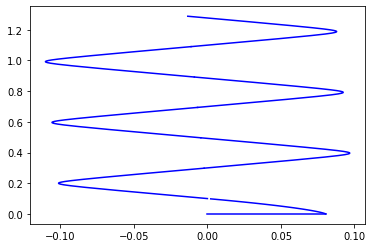

In [19]:
for idx in range(len(step_infos)):
    plt.plot(step_infos[idx].state[0, :] + step_infos[idx].footplant[0], step_infos[idx].state[2, :] + step_infos[idx].footplant[1], 'b')